In [53]:
import pandas as pd 
import numpy as np 
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt 
import distance
import json
import os
import slack
from datetime import timedelta,datetime
from sshtunnel import SSHTunnelForwarder
import psycopg2
import nbslack
import seaborn as sns

In [54]:
try:
    with SSHTunnelForwarder(
        (os.environ.get('JOUST_IP'), 22),
        ssh_private_key="~/.ssh/id_rsa",
        ssh_username="ubuntu",
        remote_bind_address=(os.environ.get('JOUST_ADDRESS'), 5432)) as server:

        server.start()
        print("server connected")

        params = {
            "database": "joust_production",
            "user": "sid",
            "password": os.environ.get('JOUST_PASS'),
            "host": "localhost",
            "port": server.local_bind_port
        }

        conn = psycopg2.connect(**params)
        curs = conn.cursor()
        print("database connected")

        #curs.execute("select * from public.account_holders")
        invoices = "select account_holders.id, first_name, last_name, businesses.name, platform, mobile_phone, email, payment_requests.id as id2, payment_requests.status, amount, account_holders.created_at, payment_requests.created_at as \"created_at.1\", accepted_date, core_pro_customers.customer_id as q2_core_pro_customer_id, payarmour_service, payment_type from account_holders inner join payment_requests on account_holders.id = payment_requests.account_holder_id left join core_pro_customers on core_pro_customers.account_holder_id = account_holders.id left join businesses on businesses.account_holder_id = account_holders.id left join account_holder_devices on account_holders.id = account_holder_devices.account_holder_id left join devices on account_holder_devices.device_id = devices.id"
        total = "select account_holders.id, account_holders.created_at, account_holders.archived, account_activations.status, account_holders.email, platform, mobile_phone, first_name, last_name, businesses.name, verification_status as q2_core_pro_verification_status, merchant_accounts.propay_status, dwolla_customers.status as dwolla_status from account_holders left join core_pro_customers on account_holders.id = core_pro_customers.account_holder_id left join account_activations on account_holders.id = account_activations.account_holder_id left join merchant_accounts on merchant_accounts.account_holder_id = account_holders.id left join dwolla_customers on account_holders.id = dwolla_customers.account_holder_id left join businesses on businesses.account_holder_id = account_holders.id left join account_holder_devices on account_holders.id = account_holder_devices.account_holder_id left join devices on account_holder_devices.device_id = devices.id order by id"
        bank = "select account_holders.id, first_name,last_name,email,bank_accounts.is_primary,bank_accounts.available_balance from account_holders inner join bank_accounts on bank_accounts.account_holder_id = account_holders.id"


        #result = curs.fetchall()
        req = pd.read_sql_query(invoices, conn)
        req.drop_duplicates(subset ="id2", inplace = True)
        total = pd.read_sql_query(total, conn) 
        total.drop_duplicates(subset ="id", inplace = True)
        bank = pd.read_sql_query(bank, conn) 

        conn.close()

except Exception as e:
    print(e)
    print("Connection Failed")

server connected
database connected


In [55]:
total = total[total['archived'] == True]
total = total[total['q2_core_pro_verification_status'] == 'verified']
#total = total[['id', 'first_name', 'last_name', 'email']]
#total.to_csv('/Users/siddhesvark/Dropbox (Joust Labs, Inc.)/Analytics/Pure Invoice Analysis/FullUserbaseWithLocked.csv')

In [56]:
len(total)

703

In [57]:
total2 = total[['id','q2_core_pro_verification_status','archived']]
total2.head()

,id,q2_core_pro_verification_status,archived
67,13,verified,True
80,25,verified,True
92,41,verified,True
98,47,verified,True
99,48,verified,True


In [58]:
bank2 = bank[bank['available_balance'] > 0]
bank2 = bank2.merge(total2, how='left',left_on='id', right_on='id')
bank2 = bank2.sort_values(by='id', ascending = True)
bank2.drop_duplicates(subset ="id", inplace = True)
bank2 = bank2.set_index('id')
bank2 = bank2.dropna()
bank2.to_csv('/Users/siddhesvark/Dropbox (Joust Labs, Inc.)/Analytics/Pure Invoice Analysis/BankAccountsWithFraud.csv')

In [5]:
total = total[total['archived'] == False]
total = total[total['q2_core_pro_verification_status'] == 'verified']
len(total)

1635

In [6]:
req['now'] = datetime.utcnow()
req['now'] = req['now'].dt.tz_localize('utc')
req['now'] = req['now'].dt.tz_convert('US/Central')
req['created_at'] = pd.to_datetime(req['created_at'])
req['created_at'] = req['created_at'].dt.tz_localize('utc')
req['created_at'] = req['created_at'].dt.tz_convert('US/Central')
req['created_at.1'] = pd.to_datetime(req['created_at.1'])
req['created_at.1'] = req['created_at.1'].dt.tz_localize('utc')
req['created_at.1'] = req['created_at.1'].dt.tz_convert('US/Central')
req['accepted_date'] = pd.to_datetime(req['accepted_date'])
req['accepted_date'] = req['accepted_date'].dt.tz_localize('utc')
req['accepted_date'] = req['accepted_date'].dt.tz_convert('US/Central')

In [7]:
req['Days since invoice'] = (req['now'] - req['created_at.1']).dt.days
req['Days to invoice'] = (req['created_at.1'] - req['created_at']).dt.days
print(req['Days since invoice'].min())
print(req['Days to invoice'].min())

0
0


In [8]:
req2 = req[req['id'] == 9]
total2 = total[total['id'] == 9]
bank2 = bank[bank['id'] == 9]
last_inv = req2['Days since invoice'].min()
first_inv = req2['Days to invoice'].min()
total_inv = len(req2)
accepted_inv = len(req2[['accepted_date']].dropna())
paid_inv = len(req2[req2['status'] == 1])
avg_inv = round(sum(req2['amount'])/len(req2),2)
avg_paid_inv = 0
if (len(req2[req2['status'] == 1]) > 0):
    avg_paid_inv = round(sum(req2[req2['status'] == 1]['amount'])/len(req2[req2['status'] == 1]),2)
fname = total2['first_name'].unique()[0]
lname = total2['last_name'].unique()[0]
email = total2['email'].unique()[0]
company = total2['name'].unique()[0]
phone = total2['mobile_phone'].unique()[0]
stat = total2['archived'].unique()[0]
if stat:
    stat = 'locked'
else:
    stat = 'unlocked'
q2 = total2['q2_core_pro_verification_status'].unique()[0]
acct_made = total2['created_at'].unique()[0]
invf = req2['created_at.1'].unique().min()
invl = req2['created_at.1'].unique().max()
bval = round(sum(bank2['available_balance']),2)
print(bval)
print(q2)

60.17
verified


In [9]:
idnum = []
daystofirst = []
dayssincelast = []
madecount = []
acccount = []
paidcount = []
avgsent = []
avgpaid = []
firstname = []
lastname = []
email = []
signup = []
fday = []
lday = []
phones = []
comps = []
q2s = []
status = []
phonetype = []
bvals = []

for k in np.sort(total['id'].unique()):
    total2 = total[total['id'] == k]
    req2 = req[req['id'] == k]
    bank2 = bank[bank['id'] == k]
    idnum.append(k)
    last_inv = req2['Days since invoice'].min()
    dayssincelast.append(last_inv)
    first_inv = req2['Days to invoice'].min()
    daystofirst.append(first_inv)
    total_inv = len(req2)
    madecount.append(total_inv)
    accepted_inv = len(req2[['accepted_date']].dropna())
    acccount.append(accepted_inv)
    paid_inv = len(req2[req2['status'] == 1])
    paidcount.append(paid_inv)
    avg_inv = 0
    if (len(req2) > 0):
        avg_inv = round(sum(req2['amount'])/len(req2),2)
    avgsent.append(avg_inv)
    avg_paid_inv = 0
    if (len(req2[req2['status'] == 1]) > 0):
        avg_paid_inv = round(sum(req2[req2['status'] == 1]['amount'])/len(req2[req2['status'] == 1]),2)
    avgpaid.append(avg_paid_inv)
    fname = total2['first_name'].unique()[0]
    firstname.append(fname)
    lname = total2['last_name'].unique()[0]
    lastname.append(lname)
    emailadd = total2['email'].unique()[0]
    email.append(emailadd)
    acct_made = total2['created_at'].unique()[0]
    signup.append(acct_made)
    company = total2['name'].unique()[0]
    comps.append(company)
    phone = total2['mobile_phone'].unique()[0]
    phones.append(phone)
    invf = req2['created_at.1'].unique().min()
    fday.append(invf)
    invl = req2['created_at.1'].unique().max()
    lday.append(invl)
    stat = total2['archived'].unique()[0]
    if stat:
        stat = 'locked'
    else:
        stat = 'unlocked'
    status.append(stat)
    q2 = total2['q2_core_pro_verification_status'].unique()[0]
    q2s.append(q2)
    pt = total2['platform'].unique()[0]
    phonetype.append(pt)
    bval = round(sum(bank2['available_balance']),2)
    bvals.append(bval)
    
fin = pd.DataFrame(idnum, columns=['id'])
fin['First Name'] = firstname
fin['Last Name'] = lastname
fin['Company'] = comps
fin['Email'] = email
fin['Phone OS'] = phonetype
fin['Phone'] = phones
fin['Account Balance'] = bvals
fin['Total Invoice Count'] = madecount
fin['Accepted Invoice Count'] = acccount
fin['Paid Invoice Count'] = paidcount
fin['Average Invoice Amount'] = avgsent
fin['Average Paid Invoice Amount'] = avgpaid
fin['Days Until First Invoice'] = daystofirst
fin['Days Since Last Invoice'] = dayssincelast
fin['Account Made Date'] = signup
fin['First Invoice Date'] = fday
fin['Last Invoice Date'] = lday
fin['Q2 Status'] = q2s
fin['Joust Status'] = status

In [10]:
len(fin[fin['Account Balance'] == 0])

1482

In [11]:
fin = fin.set_index('id')
fin.to_csv('/Users/siddhesvark/Dropbox (Joust Labs, Inc.)/Analytics/Pure Invoice Analysis/InvoiceAnalysis.csv')

In [12]:
fin[fin['Account Balance'] == 0].to_csv('/Users/siddhesvark/Dropbox (Joust Labs, Inc.)/Analytics/Pure Invoice Analysis/JoustEmptyBank.csv')

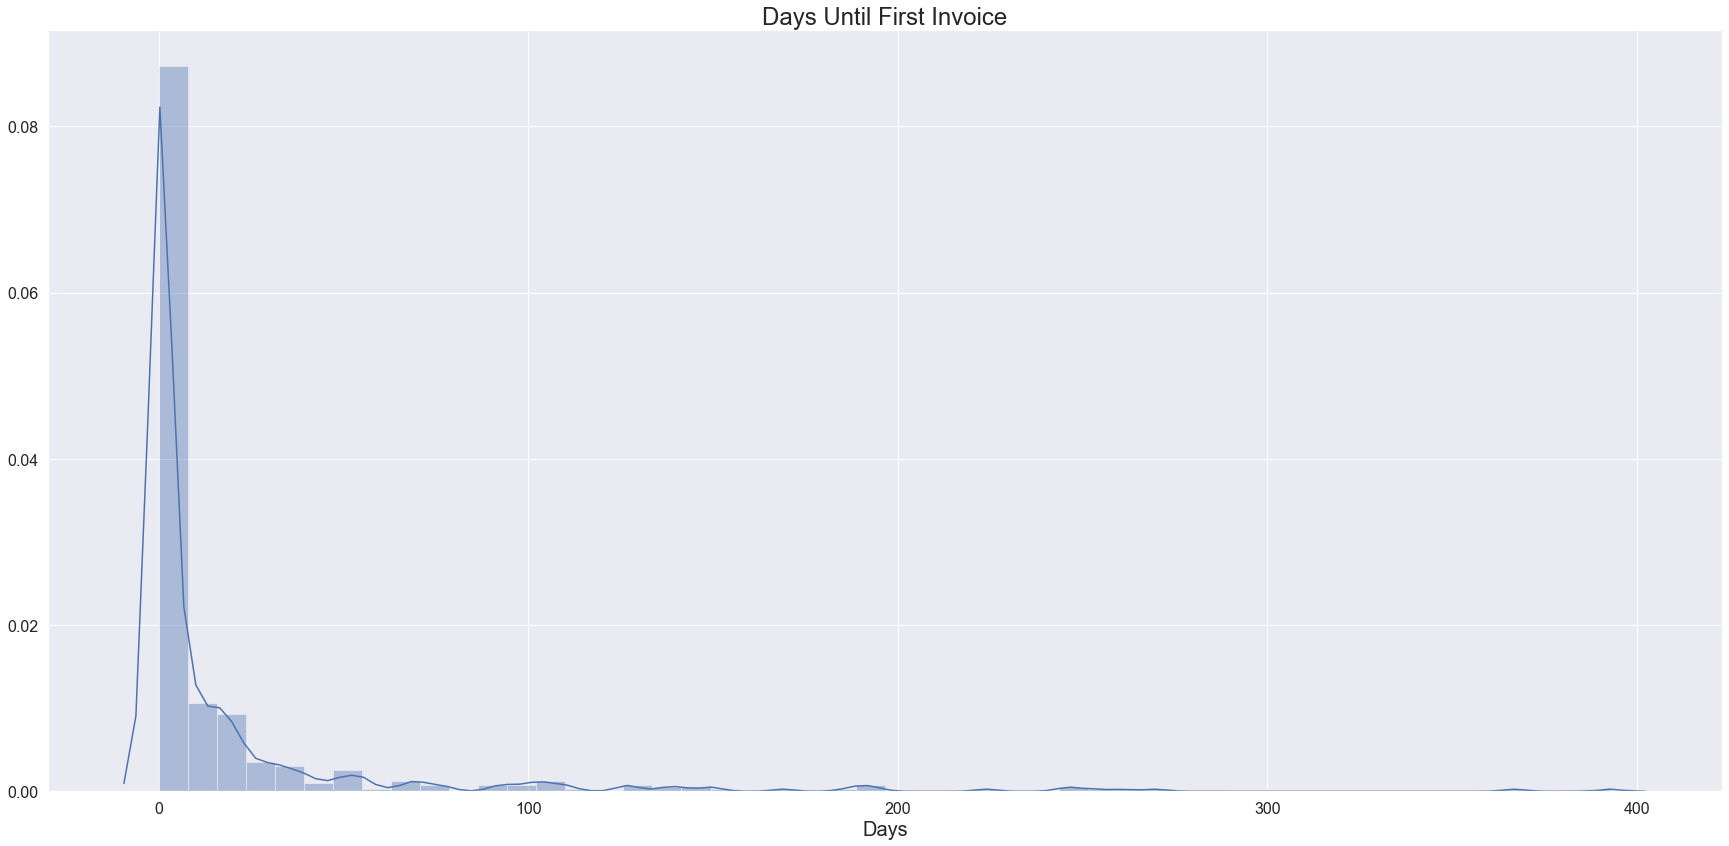

260 (48.42%) of invoicers sent their first invoice on day 0
34 (6.33%) of invoicers sent their first invoice on day 1
20 (3.72%) of invoicers sent their first invoice on day 2
9 (1.68%) of invoicers sent their first invoice on day 3
14 (2.61%) of invoicers sent their first invoice on day 4
15 (2.79%) of invoicers sent their first invoice on day 5
8 (1.49%) of invoicers sent their first invoice on day 6
8 (1.49%) of invoicers sent their first invoice on day 7
9 (1.68%) of invoicers sent their first invoice on day 8
4 (0.74%) of invoicers sent their first invoice on day 9
4 (0.74%) of invoicers sent their first invoice on day 10
9 (1.68%) of invoicers sent their first invoice on day 11
6 (1.12%) of invoicers sent their first invoice on day 12
2 (0.37%) of invoicers sent their first invoice on day 13
4 (0.74%) of invoicers sent their first invoice on day 14
7 (1.3%) of invoicers sent their first invoice on day 15
6 (1.12%) of invoicers sent their first invoice on day 16
6 (1.12%) of invoi

In [44]:
ax = sns.distplot(fin['Days Until First Invoice'])
sns.set(rc={'figure.figsize':(30,14)})
#ax = req.amount.plot.kde()
ax.set_title("Days Until First Invoice", fontsize=24)
ax.set_xlabel("Days",fontsize=20)
ax.set_ylabel("",fontsize=20)
ax.tick_params(labelsize=16)
plt.show()
for k in (np.sort(fin['Days Until First Invoice'].unique())):
    fin2 = fin[fin['Days Until First Invoice'] == k]
    print(str(len(fin2)) + ' (' + str(round(100*len(fin2)/len(fin),2)) + '%) of invoicers sent their first invoice on day ' + str(k)) 

In [13]:
fin.head()

,First Name,Last Name,Company,Email,Phone OS,Phone,Account Balance,Total Invoice Count,Accepted Invoice Count,Paid Invoice Count,Average Invoice Amount,Average Paid Invoice Amount,Days Until First Invoice,Days Since Last Invoice,Account Made Date,First Invoice Date,Last Invoice Date,Q2 Status,Joust Status
id,,,,,,,,,,,,,,,,,,,
7,Kathryn,Gruenefeldt,Gruenefeldt Consulting,kathryn.gruenefeldt@gmail.com,ios,+15037068008,14.03,51,19,7,1.96,2.14,0.0,98.0,2018-12-06 16:26:45.573220,2018-12-06 14:26:44.123514-06:00,2020-01-29 16:05:12.473287-06:00,verified,unlocked
8,Lamine,Zarrad,Joust Labs,lamine@joust.com,ios,+13039094460,37.21,95,46,14,348.93,130.90,0.0,22.0,2018-12-06 19:47:44.640272,2018-12-06 14:26:10.859296-06:00,2020-04-14 16:32:09.496232-05:00,verified,unlocked
9,George,Kurtyka,George Consulting LLC,g@george.consulting,ios,+15033695531,60.17,77,36,18,94.60,59.67,2.0,5.0,2018-12-07 23:39:37.223218,2018-12-10 16:51:34.436488-06:00,2020-05-01 15:22:20.322086-05:00,verified,unlocked
10,Jenaya,Zarrad,Lady J,jenaya.zarrad@gmail.com,None,+19703719227,5.00,7,1,0,1.69,0.00,128.0,387.0,2018-12-08 01:34:16.491605,2019-04-15 18:00:16.148536-05:00,2019-04-15 18:06:39.113000-05:00,verified,unlocked
32,THOMAS,HERSHENSON,Narratif,thersh.dc@gmail.com,None,+12024157206,0.00,0,0,0,0.00,0.00,NaN,NaN,2019-01-12 20:47:58.589287,NaT,NaT,verified,unlocked


In [14]:
fin['Company'] = fin['Company'].str.lower()
fin['Company type'] = fin['Company'].str[-3:]
fin2 = fin[fin['Company type'] == 'llc']
fin2.to_csv('/Users/siddhesvark/Dropbox (Joust Labs, Inc.)/Marketing and Design/Marketing Research/2.0 Customer Discovery/llcs.csv')